# Import necessary libraries
SAFEP_parse.py contains all the functions and library calls necessary to run the notebook
# Required libraries:
- numpy
- pandas
- matplotlib
- alchemlyb (pip install git+https://github.com/alchemistry/alchemlyb)
- natsort (for sorting file names)
- glob (for unix-like file paths)



# IMPORTANT: Make sure the temperature (set below) matches the temperature you used to run the simulations.

In [1]:
from AFEP_parse import *
plt.rcParams['figure.dpi'] = 150

In [2]:
def batchProcess(paths, RT, decorrelate):
    u_nks = {}
    affixes = {}

    #Read all
    for path in paths:
        print(f"Reading {path}")
        key = path.split('/')[-2]
        fepoutFiles = glob(path+'/'+pattern)
        u_nks[key], affix = readAndProcess(fepoutFiles, temperature, decorrelate, detectEQ)


    ls = {}
    l_mids = {}
    fs = {}
    dfs = {}
    ddfs = {}
    errorses = {}
    dG_fs = {}
    dG_bs = {}

    #do BAR fitting
    for key in u_nks:
        u_nk = u_nks[key]
        u_nk = u_nk.sort_index(level=1)
        bar = BAR()
        bar.fit(u_nk)
        ls[key], l_mids[key], fs[key], dfs[key], ddfs[key], errorses[key] = get_BAR(bar)
        
        expl, expmid, dG_fs[key], dG_bs[key] = get_EXP(u_nk)

    #Collect into dataframes - could be more pythonic but it works
    cumulative = pd.DataFrame()
    for key in ls:
        #cumulative[(key, 'l')] = ls[key]
        cumulative[(key, 'f')] = fs[key]
        cumulative[(key, 'errors')] = errorses[key]
    cumulative.columns = pd.MultiIndex.from_tuples(cumulative.columns)

    perWindow = pd.DataFrame()
    for key in ls:
        #perWindow[(key, 'l_mid')] = l_mids[key]
        perWindow[(key, 'df')] = dfs[key]
        perWindow[(key, 'ddf')] = ddfs[key]
        perWindow[(key, 'dG_f')] = dG_fs[key]
        perWindow[(key, 'dG_b')] = dG_bs[key]
    perWindow.columns = pd.MultiIndex.from_tuples(perWindow.columns)
    perWindow.index = l_mids[key]
    
    return u_nks, cumulative, perWindow, affix

In [3]:
def doConvergence(u_nk, states, tau=1):
    grouped = u_nk.groupby('fep-lambda')
    data_list = [grouped.get_group(s) for s in states]

    #return data_list
    
    forward = []
    forward_error = []
    backward = []
    backward_error = []
    num_points = 10
    for i in range(1, num_points+1):
        # forward
        #partial = pd.concat([data[:np.floor(len(data)/num_points*i)] for data in data_list])
        partial = []
        for data in data_list:
            last = data[0].index.get_level_values(0)[-1]
            first = data[0].index.get_level_values(0)[0]
            nsteps = last-first
            step = first + i*nsteps/num_points
            mask = data[0].index.get_level_values(0)<=step
            partial.append(data.loc[mask])
            
        partial = pd.concat(partial)
        estimate = BAR().fit(partial)
        
        forward.append(estimate.delta_f_.iloc[0,-1])
        # For BAR, the error estimates are off-diagonal
        ddf = [estimate.d_delta_f_.iloc[i+1,i] * np.sqrt(tau) for i in range(len(states)-1)]
        error = np.sqrt((np.array(ddf)**2).sum())
        forward_error.append(error)

        # backward
        #partial = pd.concat([data[-np.ceil(len(data)/num_points*i):] for data in data_list])
        
        
        partial = []
        for data in data_list:
            last = data[0].index.get_level_values(0)[-1]
            first = data[0].index.get_level_values(0)[0]
            nsteps = last-first
            step = last - i*nsteps/num_points
            mask = data[0].index.get_level_values(0)>=step
            partial.append(data.loc[mask])
        partial = pd.concat(partial)
        
        estimate = BAR().fit(partial)

        backward.append(estimate.delta_f_.iloc[0,-1])
        ddf = [estimate.d_delta_f_.iloc[i+1,i] * np.sqrt(tau) for i in range(len(states)-1)]
        error = np.sqrt((np.array(ddf)**2).sum())
        backward_error.append(error)

    return forward, forward_error, backward, backward_error

In [14]:
root = '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/SequentialRuns/FEP/'
pattern = 'PO*fepout'
prefix= 'POCG'
paths = glob(root+prefix+'*/')
header = 'PC:PG:PE 2:1:1'

goodpaths = []
for path in paths:
    feps = glob(path+pattern)
    countDone = 0
    for fep in feps:
        with open(fep) as f:
            if 'Free' in f.read():
                countDone+=1
    if countDone == 41:
        goodpaths.append(path)
paths = goodpaths

In [15]:
paths

['/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/SequentialRuns/FEP/POCG_22/',
 '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/SequentialRuns/FEP/POCG_5/']

In [16]:
temperature = 303.15
RT = 0.00198720650096 * temperature # ca. 0.59kcal/mol
decorrelate = True #Flag for decorrelation of samples
detectEQ = False #Flag for automated equilibrium detection
DiscrepancyFitting = 'LS' #ML = fit PDF of discrepancies with a normal distribution maximum likelihood estimator. LS = fit CDF of discrepancies with a normal distribution least-squares estimator

In [17]:
u_nks, cumulative, perWindow, affix = batchProcess(paths, RT, decorrelate)

Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/SequentialRuns/FEP/POCG_22/
Decorrelating samples. Flag='True'


/u2/home_u2/ems363/miniconda3/envs/jupEnv/lib/python3.9/site-packages/alchemlyb/preprocessing/subsampling.py:135: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  return df.sort_index(0).reset_index('time').duplicated('time').any()
/u2/home_u2/ems363/miniconda3/envs/jupEnv/lib/python3.9/site-packages/alchemlyb/preprocessing/subsampling.py:133: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  return df.sort_index(0).reset_index('time', name='').duplicated('time').any()


Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/SequentialRuns/FEP/POCG_5/
Decorrelating samples. Flag='True'


In [18]:
perWindow[('mean', 'df')] = np.mean(perWindow.loc[:, (slice(None), 'df')], axis=1)
perWindow[('mean', 'ddf')] = np.mean(perWindow.loc[:, (slice(None), 'ddf')], axis=1)
perWindow[('mean', 'dG_f')] = np.mean(perWindow.loc[:, (slice(None), 'dG_f')], axis=1)
perWindow[('mean', 'dG_b')] = np.mean(perWindow.loc[:, (slice(None), 'dG_b')], axis=1)

In [19]:
l0s = list(set(perWindow.columns.get_level_values(0)))
for key in l0s:
    perWindow[(key, 'diff')] = perWindow[(key, 'dG_f')]+perWindow[(key, 'dG_b')]

In [20]:
cumulative.loc[1, :]*RT

POCG_22  f        -13.075037
         errors     0.235170
POCG_5   f        -12.953479
         errors     0.241798
Name: 1.0, dtype: float64

In [21]:
keys = set(cumulative.columns.get_level_values(0))
colors = ['#0072B2', '#D55E00', '#CC79A7', '#009E73', '#E69F00']
keyColors = {}
i = 0
for key in keys:
    keyColors[key] = colors[i]
    i += 1

In [22]:
feps = np.sort(list(set(u_nks[l0s[1]].index.get_level_values(1))))

fs = {}
bs = {}
fes = {}
bes = {}

for l in [x for x in l0s if x != "mean"]:
    forward, forward_error, backward, backward_error = doConvergence(u_nks[l], feps)
    fs[l] = forward
    fes[l] = forward_error
    bs[l] = backward
    bes[l] = backward_error

/u2/home_u2/ems363/miniconda3/envs/jupEnv/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


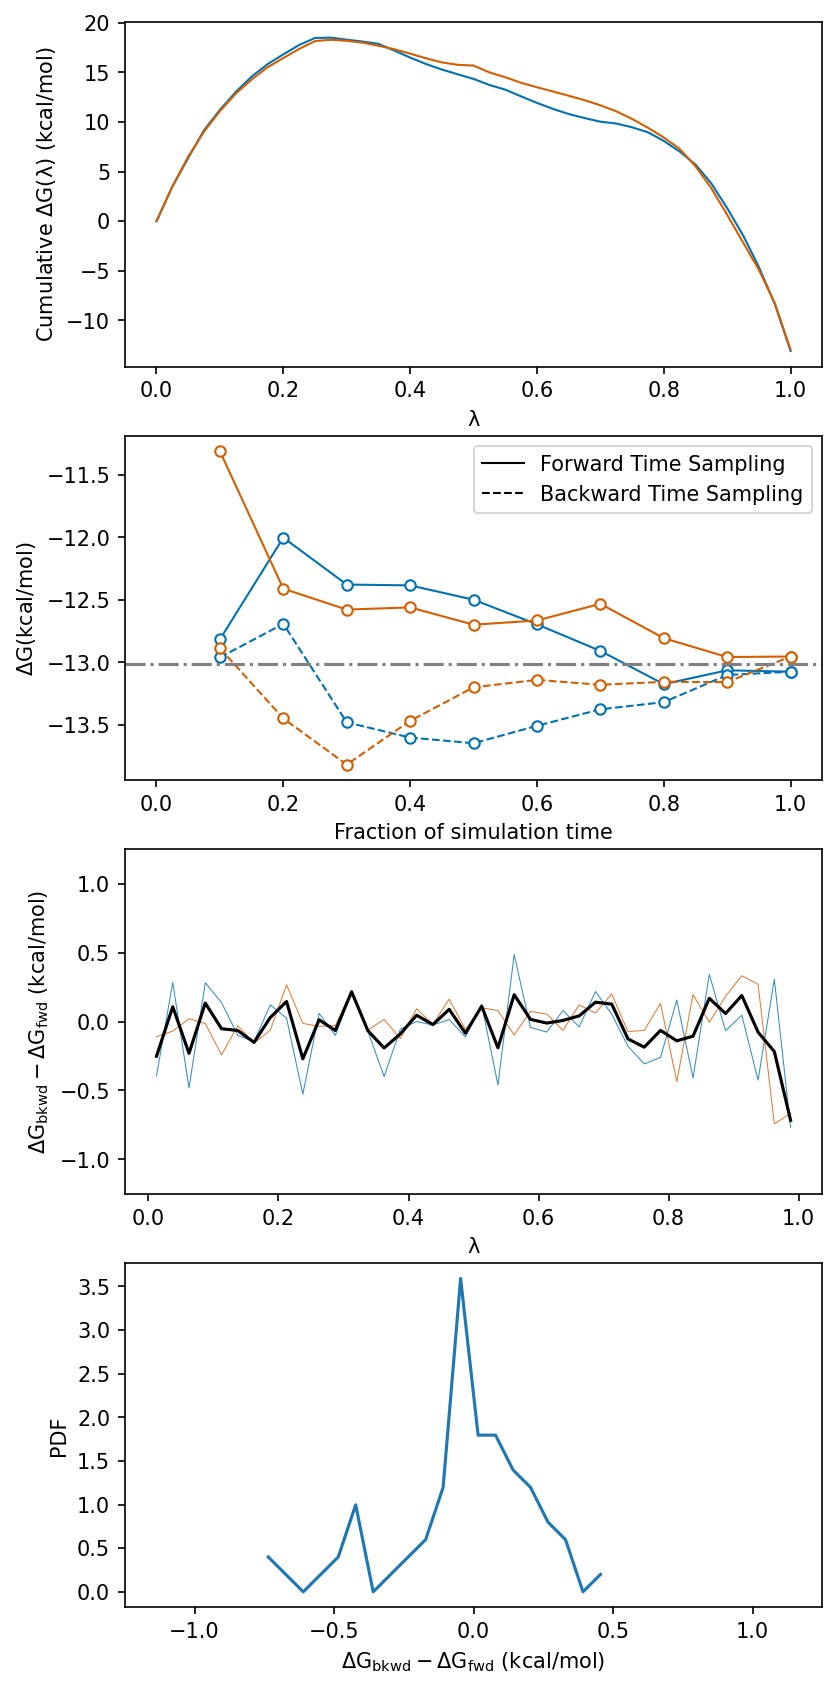

In [23]:
fig, (dGax, convax, hysax, pdfAx) = plt.subplots(4,1, sharex=False, sharey=False)

# Cumulative change in kT
for key in keys:
    dGax.plot(cumulative.index, cumulative[(key, 'f')]*RT, marker=None, label=key, linewidth=1, color=keyColors[key])
    dGax.set(xlabel=r'$\rm\lambda$', ylabel=r'Cumulative $\rm\Delta$G($\rm\lambda$) (kcal/mol)')
    #plt.legend()
    #plt.title(fr'Cumulative $\delta$Gs for {header}')

    
    
# Convergence plots
for l in [x for x in l0s if x != "mean"]:
    #plt.errorbar(np.arange(len(fs[l]))/len(fs[l])+0.1, np.multiply(fs[l], RT), yerr=np.multiply(fes[l], RT), marker='o', linewidth=1, color='mediumslateblue', markerfacecolor='white', markeredgewidth=1, markeredgecolor='mediumslateblue', ms=5)
    #plt.errorbar(np.arange(len(bs[l]))/len(fs[l])+0.1, np.multiply(bs[l], RT), yerr=np.multiply(bes[l], RT), marker='o', linewidth=1, color='red', markerfacecolor='white', markeredgewidth=1, markeredgecolor='red', ms=5)
    convax.plot(np.arange(len(fs[l]))/len(fs[l])+0.1, np.multiply(fs[l], RT), marker='o', linewidth=1, color=keyColors[l], markerfacecolor='white', markeredgewidth=1, markeredgecolor=keyColors[l], ms=5)
    convax.plot(np.arange(len(bs[l]))/len(fs[l])+0.1, np.multiply(bs[l], RT), marker='o', linewidth=1, color=keyColors[l], markerfacecolor='white', markeredgewidth=1, markeredgecolor=keyColors[l], ms=5, linestyle='--')

    
convax.set(xlabel='Fraction of simulation time', ylabel=r'$\rm\Delta G (kcal/mol)$')

#plt.plot(np.arange(len(fs[l]))/len(fs[l])+0.1, np.multiply(fs[l], RT), marker='o', linewidth=1, color=keyColors[l], markerfacecolor='white', markeredgewidth=1, markeredgecolor=keyColors[l], ms=5, label='Forward Time Sampling')
#plt.plot(np.arange(len(bs[l]))/len(fs[l])+0.1, np.multiply(bs[l], RT), marker='o', linewidth=1, color=keyColors[l], markerfacecolor='white', markeredgewidth=1, markeredgecolor=keyColors[l], ms=5, linestyle='--', label='Backward Time Sampling')



convax.xaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])

finalMean = np.mean(cumulative.loc[1, (slice(None), 'f')])
convax.axhline(y= finalMean*RT, linestyle='-.', color='gray')
convax.plot(0, finalMean*RT, linewidth=1, color='black', label='Forward Time Sampling')
convax.plot(0, finalMean*RT, linewidth=1, color='black', linestyle='--', label='Backward Time Sampling')

convax.legend()


# Hysteresis plot
for key in u_nks:
    #plt.vlines(perWindow.index, np.zeros(len(perWindow)), perWindow[(key, 'dG_f')] + perWindow[(key, 'dG_b')], label=key, linewidth=2)
    hysax.plot(perWindow.index, perWindow[(key, 'diff')]*RT, label=key, linewidth=0.5, alpha=0.8, color=keyColors[key])

hysax.plot(perWindow.index, perWindow[('mean', 'diff')]*RT, label='mean', linewidth=1.5, color='black')

hysax.set(xlabel=r'$\rm\lambda$', ylabel=r'$\rm\Delta G_{bkwd}-\Delta G_{fwd}$ (kcal/mol)', ylim=(-1.25, 1.25))


# Hysteresis PDF
diff = perWindow.loc[:, (slice(None), 'diff')]*RT
X = diff.drop(columns='mean') #Including the mean in here would underestimate the skewness of the distribution
Y = np.arange(len(X))/len(X)
binNum = 20
pdfY, pdfX = np.histogram(X, bins=binNum, density=True)
pdfX = (pdfX[1:]+pdfX[:-1])/2


#plot the data
pdfAx.plot(pdfX, pdfY,  label="Estimated Distribution")
pdfAx.set(xlim=(-1.25, 1.25), ylabel='PDF', xlabel=r'$\rm\Delta G_{bkwd}-\Delta G_{fwd}$ (kcal/mol)')





fig.set_figheight(14)
#fig.tight_layout()
plt.savefig(f"{root}/{prefix}_ALL_{affix}.pdf")

# Plot the change in free energy based on MBAR estimates

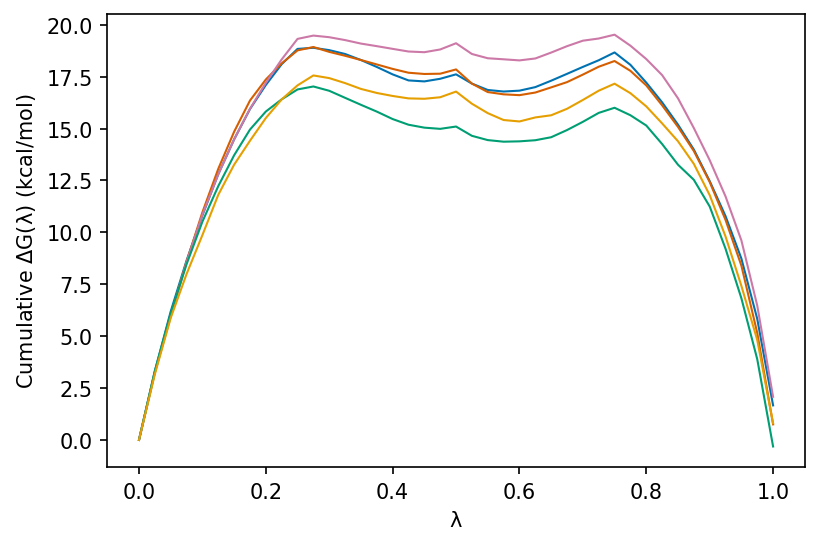

In [39]:
# Cumulative change in kT

for key in keys:
    plt.plot(cumulative.index, cumulative[(key, 'f')]*RT, marker=None, label=key, linewidth=1, color=keyColors[key])
    plt.xlabel(r'$\rm\lambda$')
    plt.ylabel(r'Cumulative $\rm\Delta$G($\rm\lambda$) (kcal/mol)')
    #plt.legend()
    #plt.title(fr'Cumulative $\delta$Gs for {header}')

plt.savefig(f"{root}/{prefix}_cumulative_{affix}.pdf")

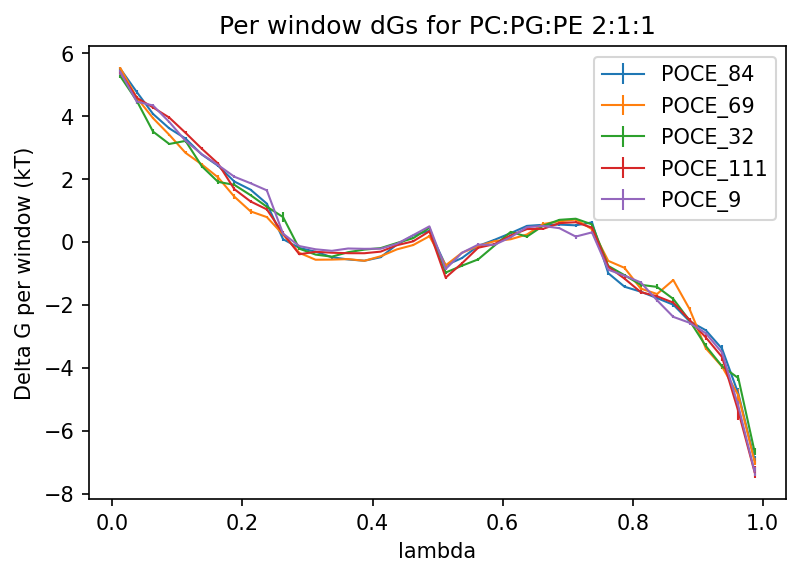

In [33]:
# Per-window change in kT

keys = set(cumulative.columns.get_level_values(0))
for key in keys:
    plt.errorbar(perWindow.index, perWindow[(key, 'df')], yerr=perWindow[(key, 'ddf')], label=key, linewidth=1)
    plt.xlabel('lambda')
    plt.ylabel('Delta G per window (kT)')
    plt.legend()
    plt.title(f'Per window dGs for {header}')
    #plt.title(f'Cumulative dG with accumulated errors {affixes[0]}\n{changeAndError}')
plt.savefig(f"{root}/{prefix}_perWindow_{affix}.pdf")

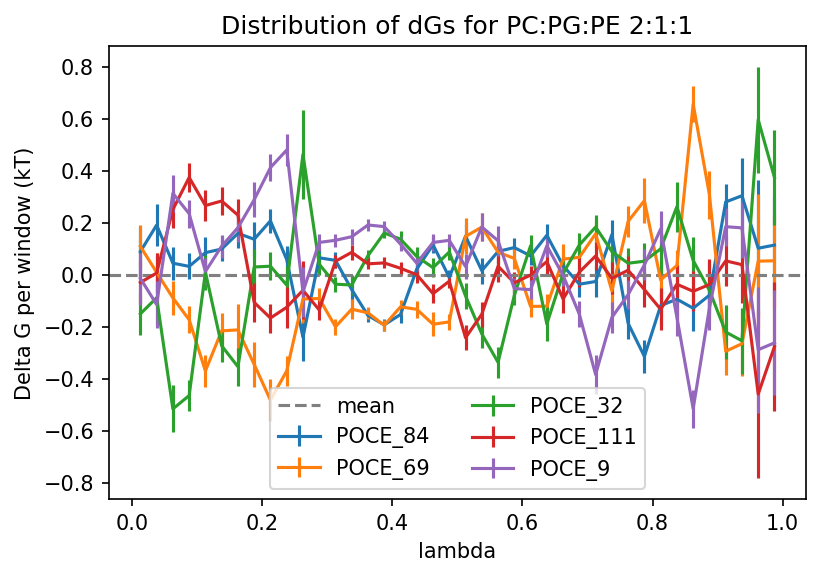

In [34]:
keys = list(set(cumulative.columns.get_level_values(0)))


for key in keys:
    plt.errorbar(perWindow.index, perWindow[(key, 'df')]-perWindow[('mean', 'df')], yerr=np.sqrt(perWindow[('mean', 'ddf')]**2 + perWindow[(key, 'ddf')]**2), label=key)
plt.xlabel('lambda')
plt.ylabel('Delta G per window (kT)')
plt.axhline(0, linestyle='--', color='grey', label='mean')
plt.legend(ncol=2)
plt.title(f'Distribution of dGs for {header}')
plt.savefig(f"{root}/{prefix}_perWindow_diff_{affix}.pdf")

# Use an exponential estimator to assess residual discrepancies and check for hysteresis

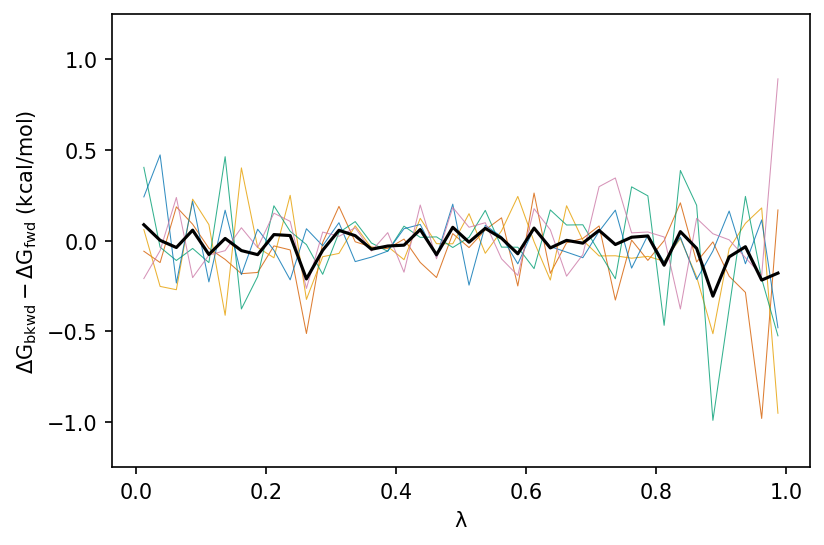

In [49]:
for key in u_nks:
    #plt.vlines(perWindow.index, np.zeros(len(perWindow)), perWindow[(key, 'dG_f')] + perWindow[(key, 'dG_b')], label=key, linewidth=2)
    plt.plot(perWindow.index, perWindow[(key, 'diff')]*RT, label=key, linewidth=0.5, alpha=0.8, color=keyColors[key])

plt.plot(perWindow.index, perWindow[('mean', 'diff')]*RT, label='mean', linewidth=1.5, color='black')

#plt.legend()
#plt.title(fr'Fwd-bwd discrepancies by $\lambda$ for {header}')
plt.xlabel(r'$\rm\lambda$')
plt.ylabel(r'$\rm\Delta G_{bkwd}-\Delta G_{fwd}$ (kcal/mol)')
plt.ylim(-1.25, 1.25)
plt.savefig(f'{root}/{prefix}_discrepancies_{affix}.pdf')

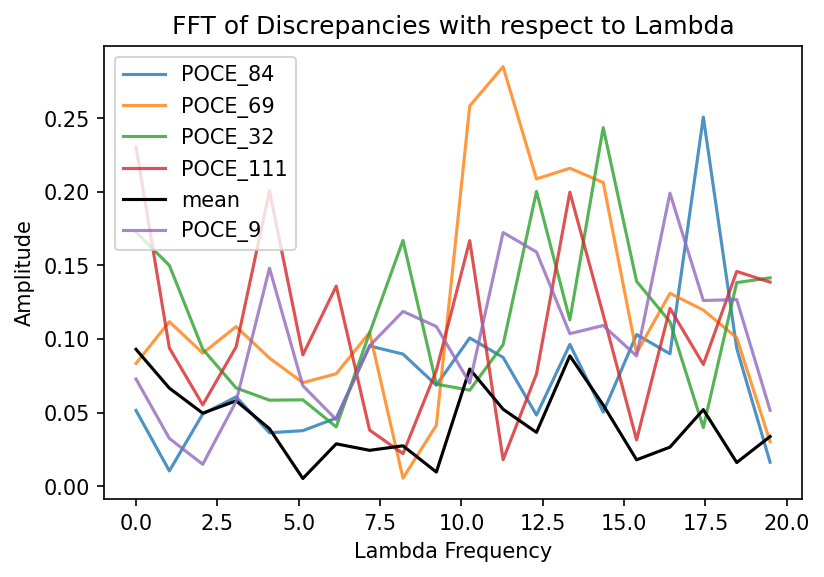

In [35]:
keys = list(set(perWindow.columns.get_level_values(0)))
for key in keys:
    myFFT = np.fft.fft(perWindow[(key, 'diff')])
    n_samples = len(perWindow)

    amplitudes = 2/n_samples * np.abs(myFFT)

    frequencies = np.fft.fftfreq(n_samples) * n_samples * 1/(perWindow.index[-1]-perWindow.index[0])
    
    if key == 'mean':
        plt.plot(frequencies[:len(frequencies)//2], amplitudes[:len(myFFT)//2], label=key, color='black')
    else:
        plt.plot(frequencies[:len(frequencies)//2], amplitudes[:len(myFFT)//2], label=key, alpha=0.8)

    plt.legend()
    plt.title(f'FFT of Discrepancies with respect to Lambda')
    plt.xlabel('Lambda Frequency')
    plt.ylabel('Amplitude')


# Estimate and plot the Probability Density Function (PDF) for the differences shown above.

In [36]:
from scipy.special import erfc
from scipy.optimize import curve_fit as scipyFit
from scipy.stats import skew
#Wrapper for fitting the normal CDF
def cumFn(x, m, s):
    r = norm.cdf(x, m, s)
    return r

def pdfFn(x,m,s):
    r = norm.pdf(x,m,s)
    return r

/tmp/ipykernel_413/889313214.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  diff = diff.drop(columns='mean')
/home/ezry/anaconda3/envs/jupEnv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/ezry/anaconda3/envs/jupEnv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/ezry/anaconda3/envs/jupEnv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: Dropping of nuisance columns in DataFrame reductio

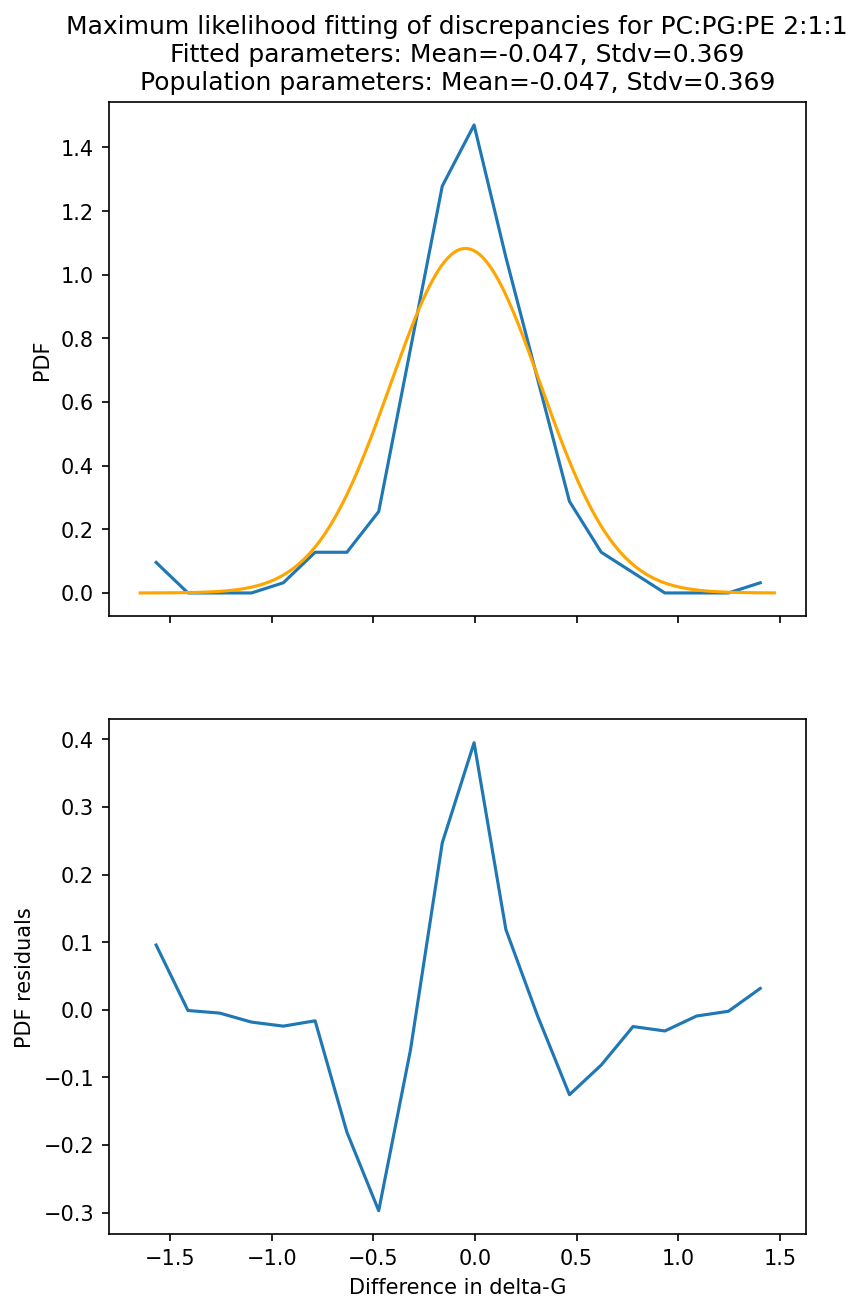

In [50]:
diff = perWindow.loc[:, (slice(None), 'diff')]
diff = diff.drop(columns='mean')
X = diff
Y = np.arange(len(X))/len(X)

#plot the data
fig, (pdfAx, pdfResid) = plt.subplots(2, 1, sharex=True)
plt.xlabel('Difference in delta-G')

#fit a normal distribution to the existing data
fitted = norm.fit(X) # fit a normal distribution to X
discrepancies = diff

#pdf
dx = 0.01

binNum = 20
pdfY, pdfX = np.histogram(discrepancies, bins=binNum, density=True)
pdfX = (pdfX[1:]+pdfX[:-1])/2

pdfXnorm  = np.arange(np.min(np.min(X)), np.max(np.max(X)), dx)
pdfYnorm = norm.pdf(pdfXnorm, fitted[0], fitted[1])

pdfYexpected = norm.pdf(pdfX, fitted[0], fitted[1])

pdfAx.plot(pdfX, pdfY,  label="Estimated Distribution")
pdfAx.set_ylabel("PDF")
pdfAx.plot(pdfXnorm, pdfYnorm, label="Fitted Normal Distribution", color="orange")

#pdf residuals
pdfResiduals = pdfY-pdfYexpected
pdfResid.plot(pdfX, pdfResiduals)
pdfResid.set_ylabel("PDF residuals") 

fig.set_figheight(10)
pdfAx.title.set_text(f"Maximum likelihood fitting of discrepancies for {header}\nFitted parameters: Mean={np.round(fitted[0],3)}, Stdv={np.round(fitted[1],3)}\nPopulation parameters: Mean={np.round(np.average(X),3)}, Stdv={np.round(np.std(X.melt()),3).value}")
plt.savefig(f"{root}/{prefix}_MaximumLikelihood_pdf_{affix}.png", dpi=600)

plt.show()

/u2/home_u2/ems363/miniconda3/envs/jupEnv/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


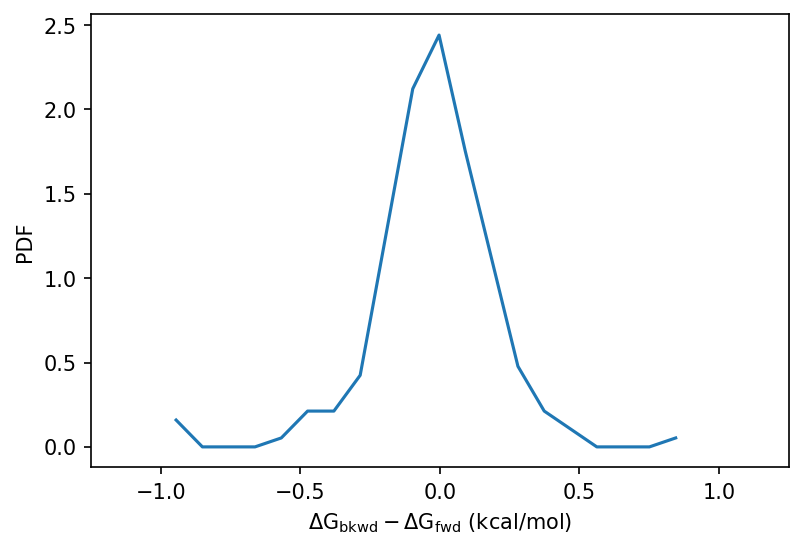

In [48]:
diff = perWindow.loc[:, (slice(None), 'diff')]*RT
diff = diff.drop(columns='mean')
X = diff
Y = np.arange(len(X))/len(X)

#plot the data
fig, pdfAx = plt.subplots(1, 1, sharex=True)
plt.xlabel(r'$\rm\Delta G_{bkwd}-\Delta G_{fwd}$ (kcal/mol)')
plt.xlim(-1.25, 1.25)

discrepancies = diff

binNum = 20
pdfY, pdfX = np.histogram(discrepancies, bins=binNum, density=True)
pdfX = (pdfX[1:]+pdfX[:-1])/2


pdfAx.plot(pdfX, pdfY,  label="Estimated Distribution")
pdfAx.set_ylabel("PDF")

plt.savefig(f"{root}/{prefix}_pdf_{affix}.pdf")

plt.show()

# Make Convergence plot(s)

In [27]:
feps = np.sort(list(set(u_nks['POCE_111'].index.get_level_values(1))))

fs = {}
bs = {}
fes = {}
bes = {}

for l in [x for x in l0s if x != "mean"]:
    forward, forward_error, backward, backward_error = doConvergence(u_nks[l], feps)
    fs[l] = forward
    fes[l] = forward_error
    bs[l] = backward
    bes[l] = backward_error
    

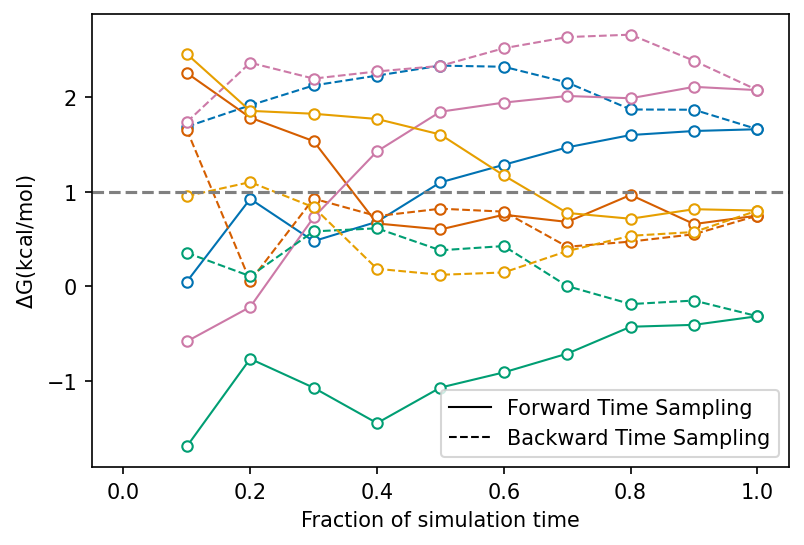

In [45]:
for l in [x for x in l0s if x != "mean"]:
    #plt.errorbar(np.arange(len(fs[l]))/len(fs[l])+0.1, np.multiply(fs[l], RT), yerr=np.multiply(fes[l], RT), marker='o', linewidth=1, color='mediumslateblue', markerfacecolor='white', markeredgewidth=1, markeredgecolor='mediumslateblue', ms=5)
    #plt.errorbar(np.arange(len(bs[l]))/len(fs[l])+0.1, np.multiply(bs[l], RT), yerr=np.multiply(bes[l], RT), marker='o', linewidth=1, color='red', markerfacecolor='white', markeredgewidth=1, markeredgecolor='red', ms=5)
    plt.plot(np.arange(len(fs[l]))/len(fs[l])+0.1, np.multiply(fs[l], RT), marker='o', linewidth=1, color=keyColors[l], markerfacecolor='white', markeredgewidth=1, markeredgecolor=keyColors[l], ms=5)
    plt.plot(np.arange(len(bs[l]))/len(fs[l])+0.1, np.multiply(bs[l], RT), marker='o', linewidth=1, color=keyColors[l], markerfacecolor='white', markeredgewidth=1, markeredgecolor=keyColors[l], ms=5, linestyle='--')

    
plt.xlabel('Fraction of simulation time')
plt.ylabel(r'$\rm\Delta G (kcal/mol)$')

#plt.plot(np.arange(len(fs[l]))/len(fs[l])+0.1, np.multiply(fs[l], RT), marker='o', linewidth=1, color=keyColors[l], markerfacecolor='white', markeredgewidth=1, markeredgecolor=keyColors[l], ms=5, label='Forward Time Sampling')
#plt.plot(np.arange(len(bs[l]))/len(fs[l])+0.1, np.multiply(bs[l], RT), marker='o', linewidth=1, color=keyColors[l], markerfacecolor='white', markeredgewidth=1, markeredgecolor=keyColors[l], ms=5, linestyle='--', label='Backward Time Sampling')

plt.plot(0, 0, linewidth=1, color='black', label='Forward Time Sampling')
plt.plot(0, 0, linewidth=1, color='black', linestyle='--', label='Backward Time Sampling')


plt.legend()
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

finalMean = np.mean(cumulative.loc[1, (slice(None), 'f')])
plt.axhline(y= finalMean*RT, linestyle='--', color='gray')

plt.savefig(f"{root}/{prefix}_convergence_{affix}.pdf")

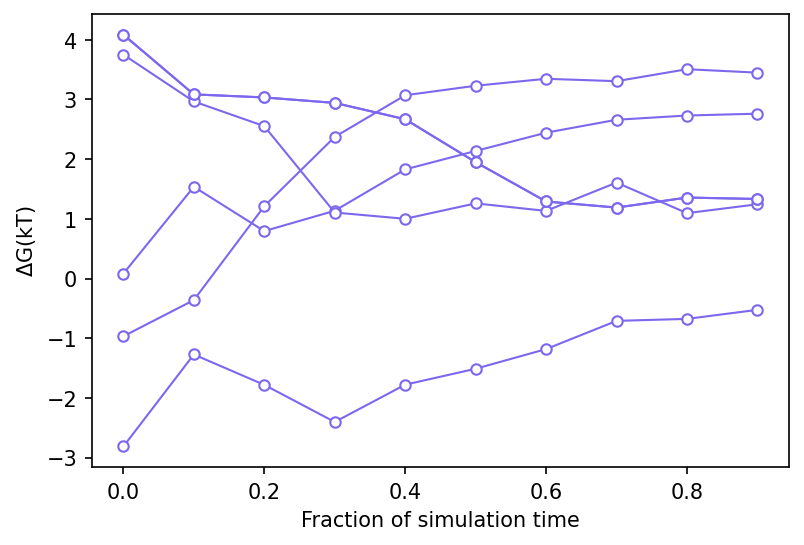

In [29]:
for l in [x for x in l0s if x != "mean"]:
    plt.plot(np.arange(len(fs[l]))/len(fs[l]), fs[l], marker='o', linewidth=1, color='mediumslateblue', markerfacecolor='white', markeredgewidth=1, markeredgecolor='mediumslateblue', ms=5)
    #plt.plot(np.arange(len(bs[l]))/len(fs[l]), bs[l], marker='o', linewidth=1, color='red', markerfacecolor='white', markeredgewidth=1, markeredgecolor='red', ms=5)
plt.xlabel('Fraction of simulation time')
plt.ylabel(r'$\rm\Delta G (kT)$')
plt.plot(np.arange(len(fs[l]))/len(fs[l]), fs[l], marker='o', linewidth=1, color='mediumslateblue', markerfacecolor='white', markeredgewidth=1, markeredgecolor='mediumslateblue', ms=5, label='Forward Sampling')
#plt.plot(np.arange(len(bs[l]))/len(fs[l]), bs[l], marker='o', linewidth=1, color='red', markerfacecolor='white', markeredgewidth=1, markeredgecolor='red', ms=5, label='Backward Sampling')
#plt.legend()

plt.savefig(f"{root}/{prefix}_convergence_fwd_{affix}.pdf")